<a href="https://colab.research.google.com/github/Jeong-HyunLee/GOBE-Reef-diversity/blob/main/GOBE_Reef_statistics_v_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Cell 1: Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import make_interp_spline
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set up visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")
plt.rcParams['figure.figsize'] = [12, 8]

# In Google Colab, Arial font might not be available
# Let's set a fallback mechanism for fonts and suppress specific font warnings
import matplotlib
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Helvetica', 'Arial', 'sans-serif']
# Filter out font warnings specifically
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
#@title Cell 2: Define Ordovician Stages and Constants

# Define the Ordovician stages with their boundaries (in Ma)
# Values from International Commission on Stratigraphy (2023)
ordovician_stages = {
    'Hirnantian': (443.8, 445.2),    # Upper Ordovician (Uppermost)
    'Katian': (445.2, 453.0),        # Upper Ordovician
    'Sandbian': (453.0, 458.4),      # Upper Ordovician
    'Darriwilian': (458.4, 467.3),   # Middle Ordovician
    'Dapingian': (467.3, 470.0),     # Middle Ordovician
    'Floian': (470.0, 477.7),        # Lower Ordovician
    'Tremadocian': (477.7, 485.4)    # Lower Ordovician (Lowermost)
}

# Calculate midpoint age for each stage
stage_midpoints = {stage: (start + end) / 2 for stage, (end, start) in ordovician_stages.items()}

# Create a DataFrame for easier handling
stages_df = pd.DataFrame([
    {'stage': stage, 'start_age': bounds[1], 'end_age': bounds[0], 'mid_age': (bounds[0] + bounds[1]) / 2}
    for stage, bounds in ordovician_stages.items()
])

# Add epoch information
stages_df['epoch'] = pd.Categorical(['Upper', 'Upper', 'Upper', 'Middle', 'Middle', 'Lower', 'Lower'],
                                   categories=['Lower', 'Middle', 'Upper'],
                                   ordered=True)

# Sort by age (oldest to youngest)
stages_df = stages_df.sort_values('start_age', ascending=False).reset_index(drop=True)

print("Ordovician stages defined:")
print(stages_df)

Ordovician stages defined:
         stage  start_age  end_age  mid_age   epoch
0  Tremadocian      485.4    477.7   481.55   Lower
1       Floian      477.7    470.0   473.85   Lower
2    Dapingian      470.0    467.3   468.65  Middle
3  Darriwilian      467.3    458.4   462.85  Middle
4     Sandbian      458.4    453.0   455.70   Upper
5       Katian      453.0    445.2   449.10   Upper
6   Hirnantian      445.2    443.8   444.50   Upper


Retrieved 2820 geological units from Macrostrat API.
Unique geometry types: ['Point']
Filtered to 1996 carbonate units.

Macrostrat data by Ordovician stages:
         stage  total_area_km2  carbonate_area_km2  carbonate_percentage
0  Tremadocian    7.454829e+06        6.192608e+06             83.068410
1       Floian    4.774902e+06        3.691614e+06             77.312861
2    Dapingian    9.107677e+05        6.364878e+05             69.884758
3  Darriwilian    8.050362e+06        4.296837e+06             53.374458
4     Sandbian    1.289061e+07        8.882741e+06             68.908627
5       Katian    2.213258e+07        1.533921e+07             69.306025
6   Hirnantian    1.160944e+06        1.001186e+06             86.239002


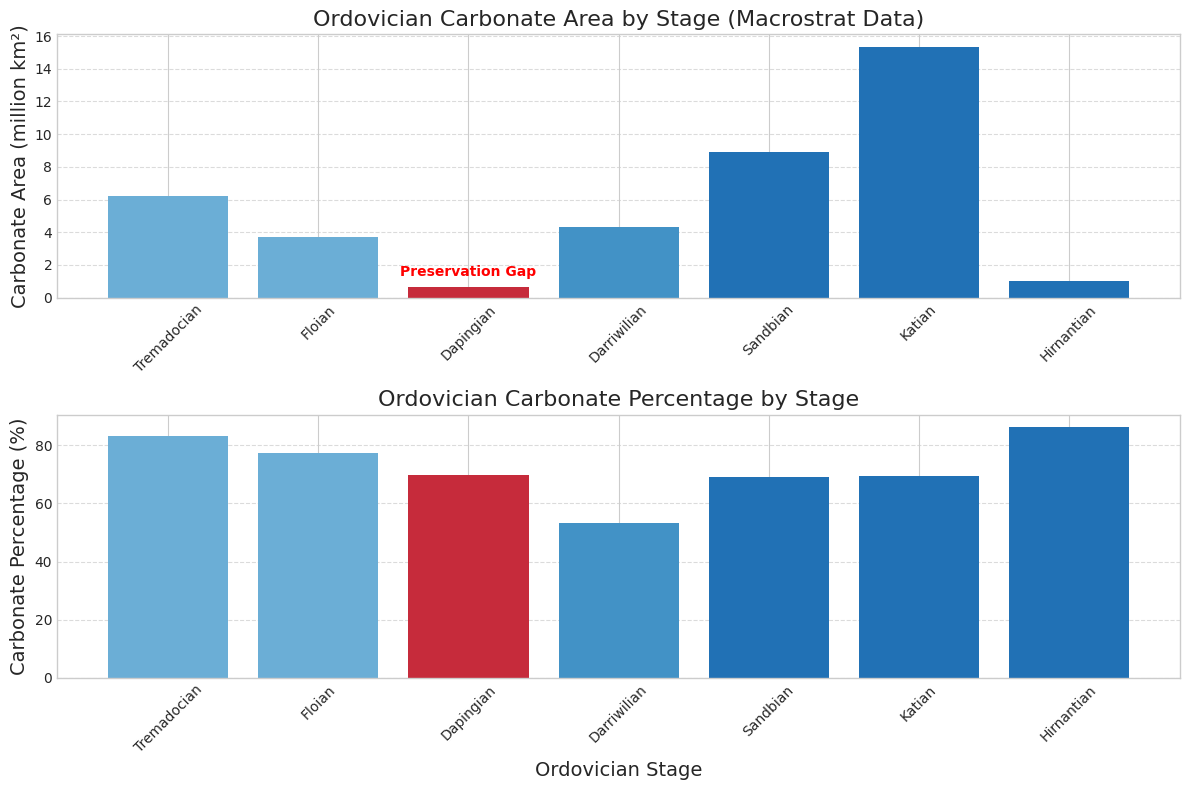

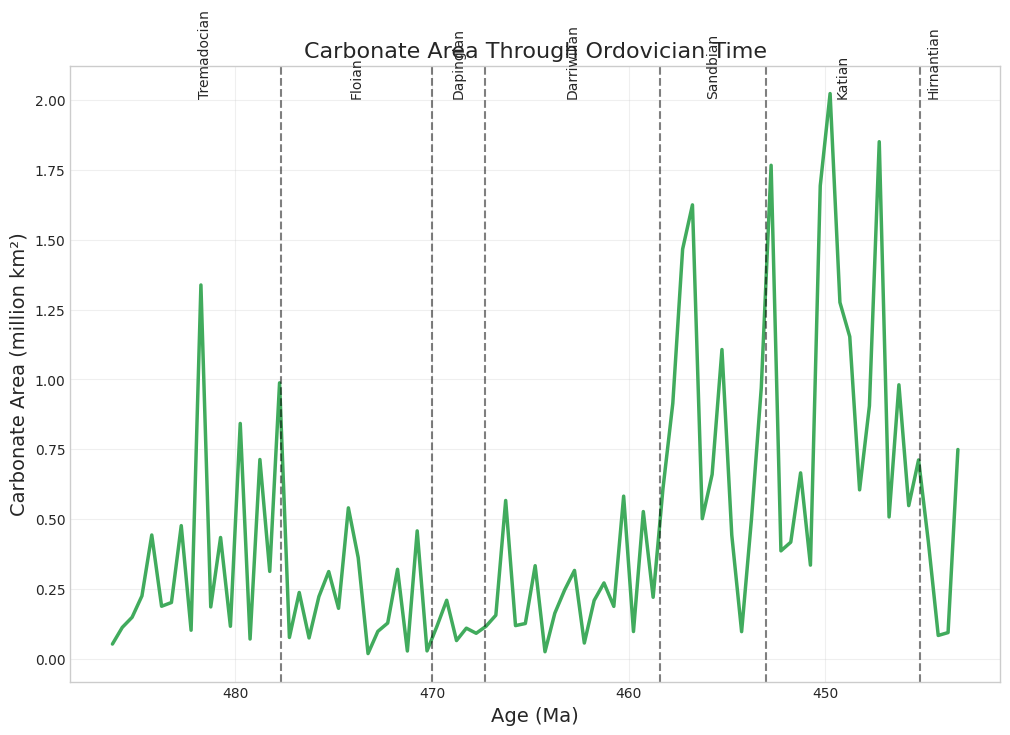


Generated macrostrat_data:
         stage  start_age  end_age  mid_age   epoch  total_area_km2  \
0  Tremadocian      485.4    477.7   481.55   Lower    7.454829e+06   
1       Floian      477.7    470.0   473.85   Lower    4.774902e+06   
2    Dapingian      470.0    467.3   468.65  Middle    9.107677e+05   
3  Darriwilian      467.3    458.4   462.85  Middle    8.050362e+06   
4     Sandbian      458.4    453.0   455.70   Upper    1.289061e+07   
5       Katian      453.0    445.2   449.10   Upper    2.213258e+07   
6   Hirnantian      445.2    443.8   444.50   Upper    1.160944e+06   

   carbonate_area_km2  carbonate_percentage  
0        6.192608e+06             83.068410  
1        3.691614e+06             77.312861  
2        6.364878e+05             69.884758  
3        4.296837e+06             53.374458  
4        8.882741e+06             68.908627  
5        1.533921e+07             69.306025  
6        1.001186e+06             86.239002  

Saved macrostrat_data to 'macrostr

In [3]:
#@title Cell 3: Process Real Macrostrat Data and Save Vector-Image PDFs

import requests
import geopandas as gpd

# Retrieve Detailed Ordovician Data (with lithology)
url = "https://macrostrat.org/api/units?interval_name=Ordovician&format=geojson&response=long"
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    features = data.get("success", {}).get("data", [])
    units = gpd.GeoDataFrame.from_features(features)
    print(f"Retrieved {len(units)} geological units from Macrostrat API.")
else:
    raise ConnectionError(f"Failed to retrieve data. Status code: {response.status_code}")

# Check if CRS is set, and set it if needed
if units.crs is None:
    units.set_crs(epsg=4326, inplace=True)
units = units.to_crs(epsg=3857)

# Calculate area based on geometry type
print("Unique geometry types:", units.geometry.geom_type.unique())
if all(g == "Point" for g in units.geometry.geom_type):
    units['area_km2'] = pd.to_numeric(units['col_area'], errors='coerce')
else:
    units['area_km2'] = units.geometry.area / 1e6

# Calculate age midpoint for each unit
units['mid_age'] = (units['t_age'] + units['b_age']) / 2.0
units.dropna(subset=['mid_age'], inplace=True)

# Identify carbonate units
def check_if_carbonate(lithologies):
    if isinstance(lithologies, list):
        for lith in lithologies:
            if 'type' in lith and 'carbonate' in lith['type'].lower():
                return True
    return False

units['is_carbonate'] = units['lith'].apply(check_if_carbonate)
carbonate_units = units[units['is_carbonate']]
print(f"Filtered to {len(carbonate_units)} carbonate units.")

# Assign each geological unit to a stage
def assign_stage(age):
    for stage, (end, start) in ordovician_stages.items():
        if start >= age >= end:
            return stage
    return None

units['stage'] = units['mid_age'].apply(assign_stage)
carbonate_units['stage'] = carbonate_units['mid_age'].apply(assign_stage)

# Group total units by stage
stage_totals = units.groupby('stage')['area_km2'].sum().reset_index()
stage_totals.rename(columns={'area_km2': 'total_area_km2'}, inplace=True)

# Group carbonate units by stage
stage_carbonates = carbonate_units.groupby('stage')['area_km2'].sum().reset_index()
stage_carbonates.rename(columns={'area_km2': 'carbonate_area_km2'}, inplace=True)

# Merge both datasets
stage_summary = pd.merge(stage_totals, stage_carbonates, on='stage', how='left')
stage_summary['carbonate_area_km2'] = stage_summary['carbonate_area_km2'].fillna(0)

# Calculate carbonate percentage
stage_summary['carbonate_percentage'] = (stage_summary['carbonate_area_km2'] / stage_summary['total_area_km2']) * 100

# Create our macrostrat_data DataFrame by merging with stage information
macrostrat_data = pd.merge(
    stages_df[['stage', 'start_age', 'end_age', 'mid_age', 'epoch']],
    stage_summary,
    on='stage',
    how='left'
)

# Sort by age (oldest to youngest)
macrostrat_data = macrostrat_data.sort_values('start_age', ascending=False).reset_index(drop=True)

# Create finer bins for time series visualization later
fine_bins = np.arange(443, 487, 0.5)
units['fine_bin'] = pd.cut(units['mid_age'], bins=fine_bins)
carbonate_units['fine_bin'] = pd.cut(carbonate_units['mid_age'], bins=fine_bins)

# Function to get bin midpoint
def bin_midpoint(interval):
    if pd.notnull(interval):
        return (interval.left + interval.right) / 2
    return np.nan

# Calculate totals for each bin
fine_total = units.groupby('fine_bin', observed=True)['area_km2'].sum().reset_index()
fine_total['bin_mid'] = fine_total['fine_bin'].apply(bin_midpoint)
fine_total.rename(columns={'area_km2': 'total_area_km2'}, inplace=True)

fine_carbonate = carbonate_units.groupby('fine_bin', observed=True)['area_km2'].sum().reset_index()
fine_carbonate['bin_mid'] = fine_carbonate['fine_bin'].apply(bin_midpoint)
fine_carbonate.rename(columns={'area_km2': 'carbonate_area_km2'}, inplace=True)

# Merge data for fine bins
fine_summary = pd.merge(fine_total, fine_carbonate, on=['fine_bin', 'bin_mid'], how='left')
fine_summary['carbonate_area_km2'] = fine_summary['carbonate_area_km2'].fillna(0)
fine_summary['carbonate_percentage'] = (fine_summary['carbonate_area_km2'] / fine_summary['total_area_km2']) * 100
fine_summary = fine_summary.sort_values('bin_mid')

# Print the results
print("\nMacrostrat data by Ordovician stages:")
print(macrostrat_data[['stage', 'total_area_km2', 'carbonate_area_km2', 'carbonate_percentage']])

# Plot real Macrostrat data to visualize preservation potential
plt.figure(figsize=(12, 8))

# Plot carbonate area by stage
ax1 = plt.subplot(211)
ax1.bar(macrostrat_data['stage'], macrostrat_data['carbonate_area_km2']/1e6,
       color=[{'Lower': '#6baed6', 'Middle': '#4292c6', 'Upper': '#2171b5'}[e] for e in macrostrat_data['epoch']])
ax1.set_title('Ordovician Carbonate Area by Stage (Macrostrat Data)', fontsize=16)
ax1.set_ylabel('Carbonate Area (million km²)', fontsize=14)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Highlight the Dapingian stage (preservation gap)
dapingian_idx = macrostrat_data[macrostrat_data['stage'] == 'Dapingian'].index
if not dapingian_idx.empty:
    dapingian_row = dapingian_idx[0]
    dapingian_value = macrostrat_data.loc[dapingian_row, 'carbonate_area_km2']/1e6
    ax1.bar(dapingian_row, dapingian_value, color='red', alpha=0.7)
    ax1.text(dapingian_row, dapingian_value + 0.5, 'Preservation Gap',
             ha='center', va='bottom', color='red', fontweight='bold')

# Plot carbonate percentage by stage
ax2 = plt.subplot(212, sharex=ax1)
ax2.bar(macrostrat_data['stage'], macrostrat_data['carbonate_percentage'],
       color=[{'Lower': '#6baed6', 'Middle': '#4292c6', 'Upper': '#2171b5'}[e] for e in macrostrat_data['epoch']])
ax2.set_title('Ordovician Carbonate Percentage by Stage', fontsize=16)
ax2.set_ylabel('Carbonate Percentage (%)', fontsize=14)
ax2.set_xlabel('Ordovician Stage', fontsize=14)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Highlight the Dapingian stage
if not dapingian_idx.empty:
    dapingian_row = dapingian_idx[0]
    dapingian_percent = macrostrat_data.loc[dapingian_row, 'carbonate_percentage']
    ax2.bar(dapingian_row, dapingian_percent, color='red', alpha=0.7)

plt.tight_layout()
# Save the figure as a vector-image PDF
plt.savefig('macrostrat_data_analysis.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Plot time series of carbonate area
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(fine_summary['bin_mid'], fine_summary['carbonate_area_km2']/1e6, '-',
       linewidth=2.5, color='#41ab5d', label='Carbonate Area')
ax.invert_xaxis()

# Add stage boundaries
for stage, (end, start) in ordovician_stages.items():
    if start != 485.4:
        ax.axvline(x=start, color='black', linestyle='--', alpha=0.5)
    mid_age = (start + end) / 2
    ax.text(mid_age, ax.get_ylim()[1]*0.95, stage, ha='center', rotation=90, fontsize=10)

ax.set_title('Carbonate Area Through Ordovician Time', fontsize=16)
ax.set_xlabel('Age (Ma)', fontsize=14)
ax.set_ylabel('Carbonate Area (million km²)', fontsize=14)
ax.grid(True, alpha=0.3)
# Save the time series plot as a vector-image PDF
plt.savefig('macrostrat_time_series.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("\nGenerated macrostrat_data:")
print(macrostrat_data)

# --- SAVE RESULTS TO CSV ---
macrostrat_data.to_csv('macrostrat_data.csv', index=False)
print("\nSaved macrostrat_data to 'macrostrat_data.csv'")


Saving df_bryozoa.csv to df_bryozoa.csv
Saving df_rugosa.csv to df_rugosa.csv
Saving df_stromatoporoid.csv to df_stromatoporoid.csv
Saving df_tabulata.csv to df_tabulata.csv
Saving reef_occurrence.csv to reef_occurrence.csv
df_tabulata columns: Index(['interval_no', 'interval_name', 'max_ma', 'min_ma', 'X_Ft', 'X_bL',
       'X_FL', 'X_bt', 'sampled_in_bin', 'implied_in_bin', 'n_occs'],
      dtype='object')
df_stromatoporoid columns: Index(['interval_no', 'interval_name', 'max_ma', 'min_ma', 'X_Ft', 'X_bL',
       'X_FL', 'X_bt', 'sampled_in_bin', 'implied_in_bin', 'n_occs'],
      dtype='object')
df_rugosa columns: Index(['interval_no', 'interval_name', 'max_ma', 'min_ma', 'X_Ft', 'X_bL',
       'X_FL', 'X_bt', 'sampled_in_bin', 'implied_in_bin', 'n_occs'],
      dtype='object')
df_bryozoa columns: Index(['interval_no', 'interval_name', 'max_ma', 'min_ma', 'X_Ft', 'X_bL',
       'X_FL', 'X_bt', 'sampled_in_bin', 'implied_in_bin', 'n_occs'],
      dtype='object')
reef_occurrence colum

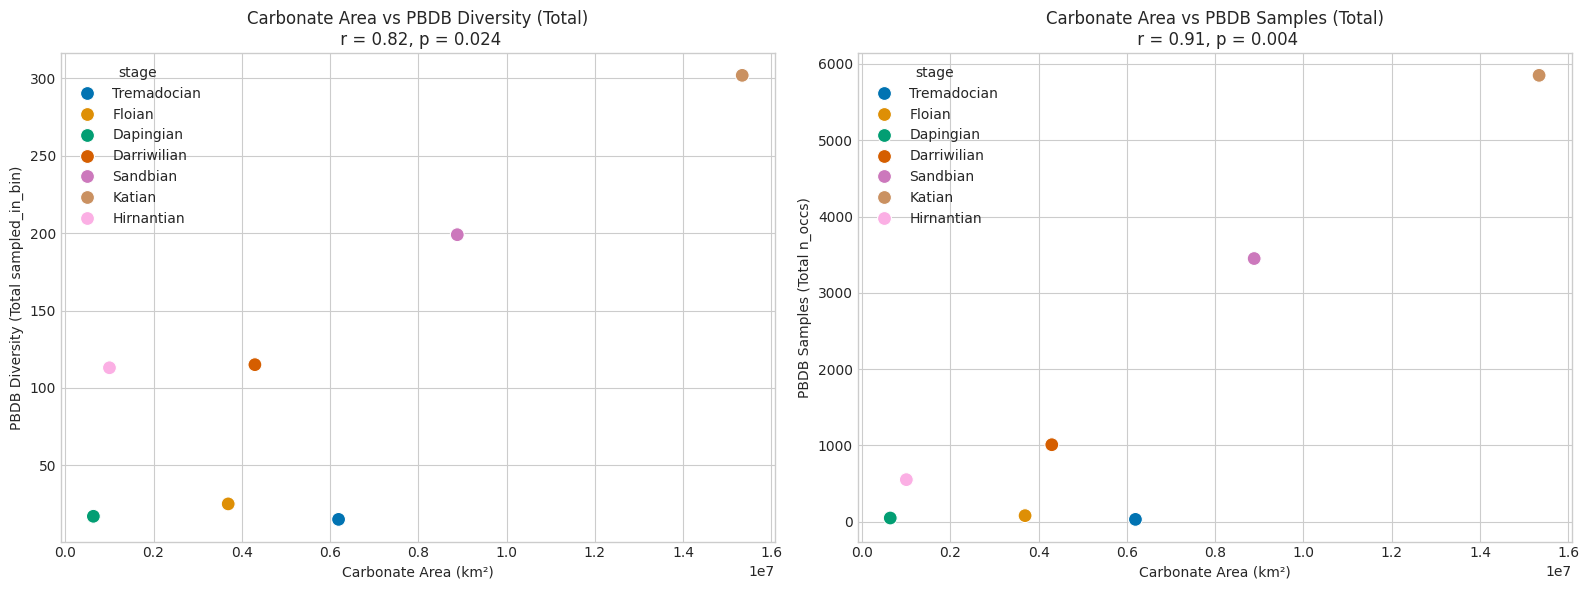

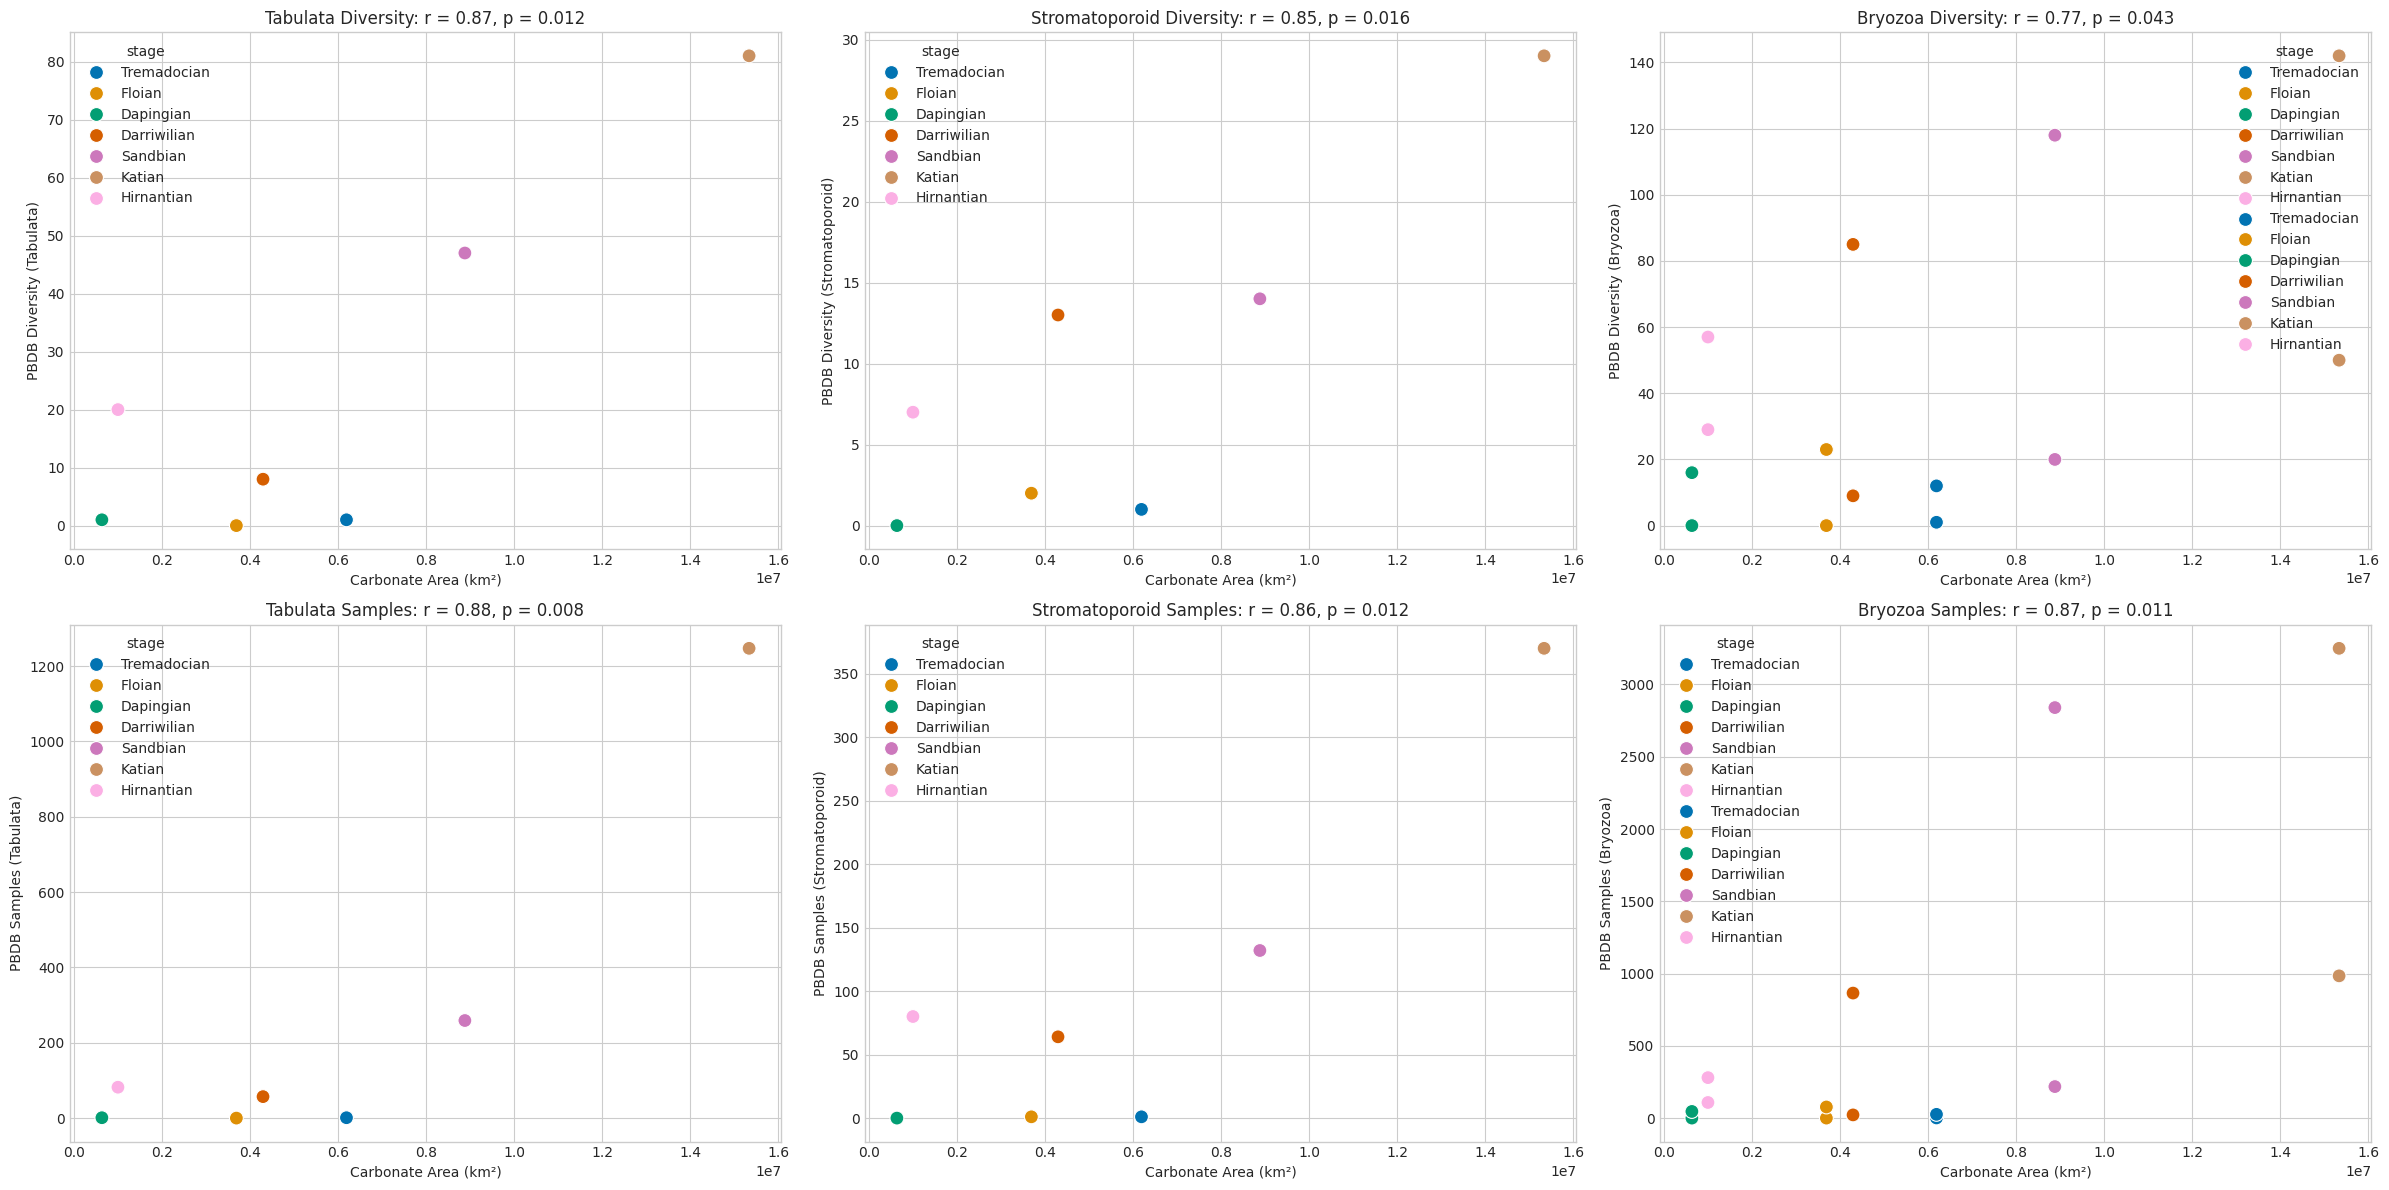

In [4]:
#@title Cell 4: Aggregated Data Analysis & Expanded Correlations with Individual Group Comparisons

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import io
from google.colab import files

# ----- Upload Files -----
# Please upload the following files:
#   - df_tabulata.csv
#   - df_stromatoporoid.csv
#   - df_rugosa.csv
#   - df_bryozoa.csv
#   - reef_occurrence.csv
uploaded = files.upload()

# Helper function: return the file content from the uploaded dict if the base string is in the key.
def get_uploaded_file(base_name):
    for key in uploaded.keys():
        if base_name in key and key.endswith('.csv'):
            return uploaded[key]
    raise KeyError(f"No uploaded file found containing '{base_name}'")

# ----- Load Files from Uploaded Data -----
# For the PBDB files, we skip the first 21 rows so that row 22 becomes the header.
df_tabulata = pd.read_csv(io.BytesIO(get_uploaded_file('df_tabulata')), skiprows=21)
df_stromatoporoid = pd.read_csv(io.BytesIO(get_uploaded_file('df_stromatoporoid')), skiprows=21)
df_rugosa = pd.read_csv(io.BytesIO(get_uploaded_file('df_rugosa')), skiprows=21)
df_bryozoa = pd.read_csv(io.BytesIO(get_uploaded_file('df_bryozoa')), skiprows=21)

# For reef_occurrence, the header is on the first row.
reef_occurrence = pd.read_csv(io.BytesIO(get_uploaded_file('reef_occurrence')))

# ----- Verify the Loaded Columns -----
print("df_tabulata columns:", df_tabulata.columns)
print("df_stromatoporoid columns:", df_stromatoporoid.columns)
print("df_rugosa columns:", df_rugosa.columns)
print("df_bryozoa columns:", df_bryozoa.columns)
print("reef_occurrence columns:", reef_occurrence.columns)

# ----- Section 1: Aggregate PBDB Data by Stage for Each Group -----
# "interval_name" is used to indicate the stage.
# "sampled_in_bin" is the diversity measure and "n_occs" is the number of samples.

# -- Diversity Aggregation --
div_tabulata = (df_tabulata.groupby("interval_name")["sampled_in_bin"]
                .sum()
                .reset_index()
                .rename(columns={"sampled_in_bin": "pbdb_div_tabulata"}))
div_stromatoporoid = (df_stromatoporoid.groupby("interval_name")["sampled_in_bin"]
                       .sum()
                       .reset_index()
                       .rename(columns={"sampled_in_bin": "pbdb_div_stromatoporoid"}))
div_rugosa = (df_rugosa.groupby("interval_name")["sampled_in_bin"]
              .sum()
              .reset_index()
              .rename(columns={"sampled_in_bin": "pbdb_div_rugosa"}))
div_bryozoa = (df_bryozoa.groupby("interval_name")["sampled_in_bin"]
              .sum()
              .reset_index()
              .rename(columns={"sampled_in_bin": "pbdb_div_bryozoa"}))

# -- Samples Aggregation --
samples_tabulata = (df_tabulata.groupby("interval_name")["n_occs"]
                    .sum()
                    .reset_index()
                    .rename(columns={"n_occs": "pbdb_samples_tabulata"}))
samples_stromatoporoid = (df_stromatoporoid.groupby("interval_name")["n_occs"]
                          .sum()
                          .reset_index()
                          .rename(columns={"n_occs": "pbdb_samples_stromatoporoid"}))
samples_rugosa = (df_rugosa.groupby("interval_name")["n_occs"]
                  .sum()
                  .reset_index()
                  .rename(columns={"n_occs": "pbdb_samples_rugosa"}))
samples_bryozoa = (df_bryozoa.groupby("interval_name")["n_occs"]
                  .sum()
                  .reset_index()
                  .rename(columns={"n_occs": "pbdb_samples_bryozoa"}))

# Merge diversity data across groups.
pbdb_div_agg = div_tabulata.merge(div_stromatoporoid, on="interval_name", how="outer")
pbdb_div_agg = pbdb_div_agg.merge(div_rugosa, on="interval_name", how="outer")
pbdb_div_agg = pbdb_div_agg.merge(div_bryozoa, on="interval_name", how="outer")
pbdb_div_agg = pbdb_div_agg.rename(columns={"interval_name": "stage"})

# Merge sample data across groups.
pbdb_samples_agg = samples_tabulata.merge(samples_stromatoporoid, on="interval_name", how="outer")
pbdb_samples_agg = pbdb_samples_agg.merge(samples_rugosa, on="interval_name", how="outer")
pbdb_samples_agg = pbdb_samples_agg.merge(samples_bryozoa, on="interval_name", how="outer")
pbdb_samples_agg = pbdb_samples_agg.rename(columns={"interval_name": "stage"})

# Compute totals across groups.
pbdb_div_agg["pbdb_div_total"] = (pbdb_div_agg["pbdb_div_tabulata"].fillna(0) +
                                  pbdb_div_agg["pbdb_div_stromatoporoid"].fillna(0) +
                                  pbdb_div_agg["pbdb_div_rugosa"].fillna(0) + # Corrected indentation
                                  pbdb_div_agg["pbdb_div_bryozoa"].fillna(0)) # Corrected indentation
pbdb_samples_agg["pbdb_samples_total"] = (pbdb_samples_agg["pbdb_samples_tabulata"].fillna(0) +
                                          pbdb_samples_agg["pbdb_samples_stromatoporoid"].fillna(0) +
                                          pbdb_samples_agg["pbdb_samples_rugosa"].fillna(0) + # Corrected indentation
                                          pbdb_samples_agg["pbdb_samples_bryozoa"].fillna(0)) # Corrected indentation

print("\nAggregated PBDB Diversity Data by Stage:")
print(pbdb_div_agg)
print("\nAggregated PBDB Sample Data by Stage:")
print(pbdb_samples_agg)

# ----- Section 2: Aggregated Data from Other Sources -----
# Macrostrat data is assumed to be available as macrostrat_data with a "stage" column.
print("\nMacrostrat Data by Stage (All Rows):")
print(macrostrat_data)

# Kiessling reef occurrence data: expected columns include "Series", "Stage", "Reefs #", and "Reef # / Ma".
kiessling_stage = (reef_occurrence.groupby("Stage")
                   .agg({
                       "Reefs #": "sum",      # Total reefs per stage
                       "Reef # / Ma": "mean"   # Average reef density per stage
                   })
                   .reset_index()
                   .rename(columns={"Stage": "stage",
                                    "Reefs #": "kiessling_reefs",
                                    "Reef # / Ma": "kiessling_density"}))
print("\nKiessling Reef Occurrence Data Aggregated by Stage (All Rows):")
print(kiessling_stage)

# ----- Section 3: Merge All Data by Stage -----
# Merge Macrostrat data with PBDB diversity and sample aggregates.
merged_div = pd.merge(macrostrat_data, pbdb_div_agg, on="stage", how="inner")
merged_div = pd.merge(merged_div, kiessling_stage, on="stage", how="inner")

merged_samples = pd.merge(macrostrat_data, pbdb_samples_agg, on="stage", how="inner")
merged_samples = pd.merge(merged_samples, kiessling_stage, on="stage", how="inner")

print("\nMerged Data by Stage (Diversity):")
print(merged_div)
print("\nMerged Data by Stage (Samples):")
print(merged_samples)

# ----- Section 4: Compute Correlations -----
# Convert necessary columns to numeric.
cols_div = ["carbonate_area_km2", "carbonate_percentage", "pbdb_div_total",
            "pbdb_div_tabulata", "pbdb_div_stromatoporoid", "pbdb_div_rugosa","pbdb_div_bryozoa",
            "kiessling_reefs"]
for col in cols_div:
    merged_div[col] = pd.to_numeric(merged_div[col], errors="coerce")

cols_samples = ["carbonate_area_km2", "carbonate_percentage", "pbdb_samples_total",
                "pbdb_samples_tabulata", "pbdb_samples_stromatoporoid", "pbdb_samples_rugosa", "pbdb_samples_bryozoa",
                "kiessling_reefs"]
for col in cols_samples:
    merged_samples[col] = pd.to_numeric(merged_samples[col], errors="coerce")

# Aggregated correlations:
div_total_r, div_total_p = pearsonr(merged_div["carbonate_area_km2"], merged_div["pbdb_div_total"])
reef_div_r, reef_div_p = pearsonr(merged_div["carbonate_area_km2"], merged_div["kiessling_reefs"])

samples_total_r, samples_total_p = pearsonr(merged_samples["carbonate_area_km2"], merged_samples["pbdb_samples_total"])
reef_samples_r, reef_samples_p = pearsonr(merged_samples["carbonate_area_km2"], merged_samples["kiessling_reefs"])

print("\nAggregated Diversity Correlations:")
print(f"Carbonate area vs PBDB Diversity (Total): r = {div_total_r:.2f}, p = {div_total_p:.3f}")
print(f"Carbonate area vs Kiessling Reef Occurrence: r = {reef_div_r:.2f}, p = {reef_div_p:.3f}")

print("\nAggregated Samples Correlations:")
print(f"Carbonate area vs PBDB Samples (Total): r = {samples_total_r:.2f}, p = {samples_total_p:.3f}")
print(f"Carbonate area vs Kiessling Reef Occurrence: r = {reef_samples_r:.2f}, p = {reef_samples_p:.3f}")

# Individual group correlations for Diversity:
r_div_tabulata, p_div_tabulata = pearsonr(merged_div["carbonate_area_km2"], merged_div["pbdb_div_tabulata"])
r_div_stromatoporoid, p_div_stromatoporoid = pearsonr(merged_div["carbonate_area_km2"], merged_div["pbdb_div_stromatoporoid"])
r_div_rugosa, p_div_rugosa = pearsonr(merged_div["carbonate_area_km2"], merged_div["pbdb_div_rugosa"])
r_div_bryozoa, p_div_bryozoa = pearsonr(merged_div["carbonate_area_km2"], merged_div["pbdb_div_bryozoa"])

print("\nIndividual Diversity Correlations:")
print(f"Carbonate area vs PBDB Diversity (Tabulata): r = {r_div_tabulata:.2f}, p = {p_div_tabulata:.3f}")
print(f"Carbonate area vs PBDB Diversity (Stromatoporoid): r = {r_div_stromatoporoid:.2f}, p = {p_div_stromatoporoid:.3f}")
print(f"Carbonate area vs PBDB Diversity (Rugosa): r = {r_div_rugosa:.2f}, p = {p_div_rugosa:.3f}")
print(f"Carbonate area vs PBDB Diversity (Bryozoa): r = {r_div_bryozoa:.2f}, p = {p_div_bryozoa:.3f}")

# Individual group correlations for Samples:
r_samples_tabulata, p_samples_tabulata = pearsonr(merged_samples["carbonate_area_km2"], merged_samples["pbdb_samples_tabulata"])
r_samples_stromatoporoid, p_samples_stromatoporoid = pearsonr(merged_samples["carbonate_area_km2"], merged_samples["pbdb_samples_stromatoporoid"])
r_samples_rugosa, p_samples_rugosa = pearsonr(merged_samples["carbonate_area_km2"], merged_samples["pbdb_samples_rugosa"])
r_samples_bryozoa, p_samples_bryozoa = pearsonr(merged_samples["carbonate_area_km2"], merged_samples["pbdb_samples_bryozoa"])

print("\nIndividual Samples Correlations:")
print(f"Carbonate area vs PBDB Samples (Tabulata): r = {r_samples_tabulata:.2f}, p = {p_samples_tabulata:.3f}")
print(f"Carbonate area vs PBDB Samples (Stromatoporoid): r = {r_samples_stromatoporoid:.2f}, p = {p_samples_stromatoporoid:.3f}")
print(f"Carbonate area vs PBDB Samples (Rugosa): r = {r_samples_rugosa:.2f}, p = {p_samples_rugosa:.3f}")
print(f"Carbonate area vs PBDB Samples (Bryozoa): r = {r_samples_bryozoa:.2f}, p = {p_samples_bryozoa:.3f}")

# ----- Section 5: Plotting -----
# Plot aggregated diversity and samples comparisons.
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(data=merged_div, x="carbonate_area_km2", y="pbdb_div_total", hue="stage", ax=axes[0], s=100)
axes[0].set_title(f"Carbonate Area vs PBDB Diversity (Total)\n r = {div_total_r:.2f}, p = {div_total_p:.3f}")
axes[0].set_xlabel("Carbonate Area (km²)")
axes[0].set_ylabel("PBDB Diversity (Total sampled_in_bin)")

sns.scatterplot(data=merged_samples, x="carbonate_area_km2", y="pbdb_samples_total", hue="stage", ax=axes[1], s=100)
axes[1].set_title(f"Carbonate Area vs PBDB Samples (Total)\n r = {samples_total_r:.2f}, p = {samples_total_p:.3f}")
axes[1].set_xlabel("Carbonate Area (km²)")
axes[1].set_ylabel("PBDB Samples (Total n_occs)")

plt.tight_layout()
plt.show()

# Additional Plot: Individual Group Comparisons (2x3 panel)
fig, axes = plt.subplots(2, 3, figsize=(24, 12))

# Diversity plots
sns.scatterplot(data=merged_div, x="carbonate_area_km2", y="pbdb_div_tabulata", hue="stage", ax=axes[0,0], s=100)
axes[0,0].set_title(f"Tabulata Diversity: r = {r_div_tabulata:.2f}, p = {p_div_tabulata:.3f}")
axes[0,0].set_xlabel("Carbonate Area (km²)")
axes[0,0].set_ylabel("PBDB Diversity (Tabulata)")

sns.scatterplot(data=merged_div, x="carbonate_area_km2", y="pbdb_div_stromatoporoid", hue="stage", ax=axes[0,1], s=100)
axes[0,1].set_title(f"Stromatoporoid Diversity: r = {r_div_stromatoporoid:.2f}, p = {p_div_stromatoporoid:.3f}")
axes[0,1].set_xlabel("Carbonate Area (km²)")
axes[0,1].set_ylabel("PBDB Diversity (Stromatoporoid)")

sns.scatterplot(data=merged_div, x="carbonate_area_km2", y="pbdb_div_rugosa", hue="stage", ax=axes[0,2], s=100)
axes[0,2].set_title(f"Rugosa Diversity: r = {r_div_rugosa:.2f}, p = {p_div_rugosa:.3f}")
axes[0,2].set_xlabel("Carbonate Area (km²)")
axes[0,2].set_ylabel("PBDB Diversity (Rugosa)")

sns.scatterplot(data=merged_div, x="carbonate_area_km2", y="pbdb_div_bryozoa", hue="stage", ax=axes[0,2], s=100)
axes[0,2].set_title(f"Bryozoa Diversity: r = {r_div_bryozoa:.2f}, p = {p_div_bryozoa:.3f}")
axes[0,2].set_xlabel("Carbonate Area (km²)")
axes[0,2].set_ylabel("PBDB Diversity (Bryozoa)")

# Samples plots
sns.scatterplot(data=merged_samples, x="carbonate_area_km2", y="pbdb_samples_tabulata", hue="stage", ax=axes[1,0], s=100)
axes[1,0].set_title(f"Tabulata Samples: r = {r_samples_tabulata:.2f}, p = {p_samples_tabulata:.3f}")
axes[1,0].set_xlabel("Carbonate Area (km²)")
axes[1,0].set_ylabel("PBDB Samples (Tabulata)")

sns.scatterplot(data=merged_samples, x="carbonate_area_km2", y="pbdb_samples_stromatoporoid", hue="stage", ax=axes[1,1], s=100)
axes[1,1].set_title(f"Stromatoporoid Samples: r = {r_samples_stromatoporoid:.2f}, p = {p_samples_stromatoporoid:.3f}")
axes[1,1].set_xlabel("Carbonate Area (km²)")
axes[1,1].set_ylabel("PBDB Samples (Stromatoporoid)")

sns.scatterplot(data=merged_samples, x="carbonate_area_km2", y="pbdb_samples_rugosa", hue="stage", ax=axes[1,2], s=100)
axes[1,2].set_title(f"Rugosa Samples: r = {r_samples_rugosa:.2f}, p = {p_samples_rugosa:.3f}")
axes[1,2].set_xlabel("Carbonate Area (km²)")
axes[1,2].set_ylabel("PBDB Samples (Rugosa)")

sns.scatterplot(data=merged_samples, x="carbonate_area_km2", y="pbdb_samples_bryozoa", hue="stage", ax=axes[1,2], s=100)
axes[1,2].set_title(f"Bryozoa Samples: r = {r_samples_bryozoa:.2f}, p = {p_samples_bryozoa:.3f}")
axes[1,2].set_xlabel("Carbonate Area (km²)")
axes[1,2].set_ylabel("PBDB Samples (Bryozoa)")

plt.tight_layout()
plt.show()
